<hr style="border:2px solid gray">

##### Author  : SIVA VIKNESH & YOUNES TATARI
##### Email   : siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com , younes.tatari@utah.edu/ younes.tatari@gmail.com
##### Address : SCI INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA 
<hr style="border:2px solid gray">

In [1]:
import numpy as np
import torch
from scipy import integrate
import matplotlib.pyplot as plt
import os
import math
import itertools
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]
np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True, precision=15)

Combustion:  <br>
Paper: Symbolic regression via neural networks : 
\
Chemical kinetics with Arrhenius rate dependence


$$
\dot{\alpha} = -k \alpha  e^{1.015\theta} + \mu
$$

$$
\dot{\theta} = \alpha e^{1.025\theta} - \theta
$$

Parameters: \\(k\\), \\(\mu\\)

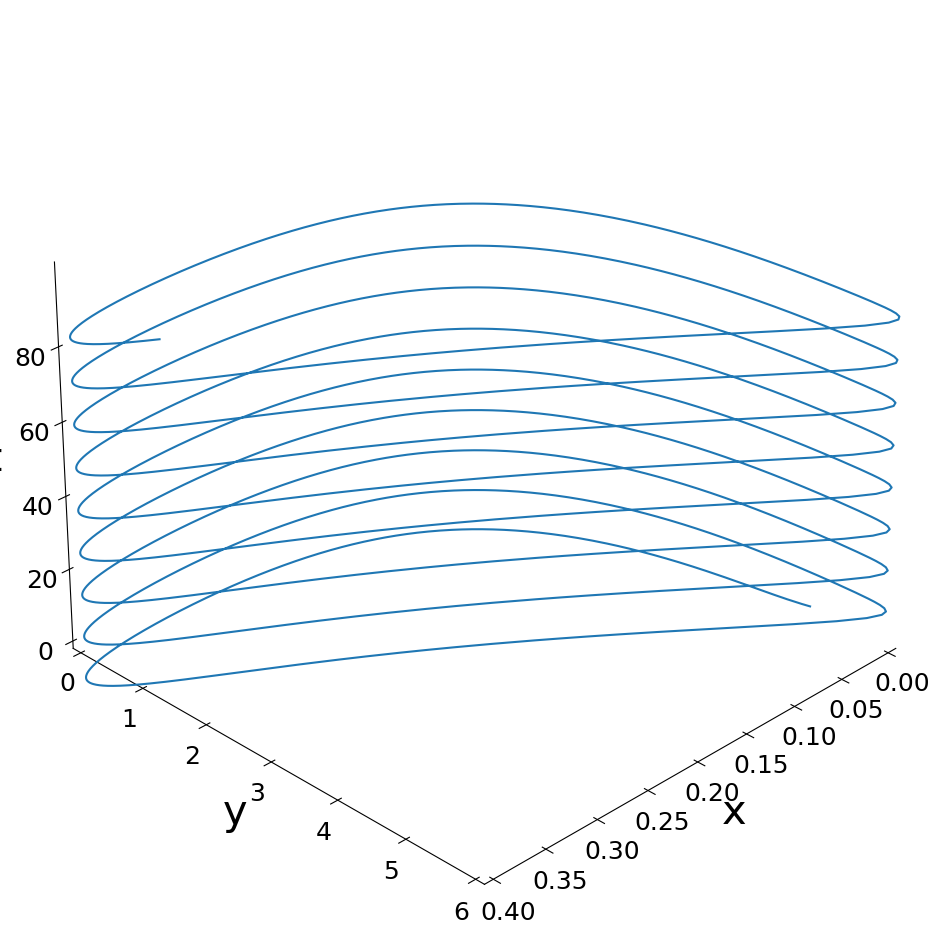

In [2]:
k  = 0.07
mu = 0.1
a  = 1.015
b  = 1.025

def oscillator_deriv(x_y, t0, a =a, b =b,  k=k, mu =mu):
    x, y = x_y
    dxdt = -k*x*np.exp(a*y) + mu
    dydt = x*np.exp(b*y) - y
    return [dxdt, dydt]

np.random.seed(123)
x0 = (0.0,5.0)

# Time points
t = np.linspace(0, 200, 10000)

x_t = integrate.odeint(oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x, y = x_t.T

# Create figure and 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plotting the data
ax.plot(x[t<=100], y[t<=100], t[t<=100])

# Setting labels with Times New Roman font
ax.set_xlabel("x", labelpad=8, fontsize = 30)
ax.set_ylabel("y", labelpad=8, fontsize = 30)
ax.set_zlabel("t", labelpad=8, fontsize = 30)

# Set limits for x and y axes
ax.set_xlim(0, 0.4)
ax.set_ylim(0, 6)

# Remove background pane and borders
ax.xaxis.pane.fill = False  # Remove background pane for x-axis
ax.yaxis.pane.fill = False  # Remove background pane for y-axis
ax.zaxis.pane.fill = False  # Remove background pane for z-axis

# Turn off the pane borders
ax.xaxis.pane.set_edgecolor('none')  # No border for x-axis pane
ax.yaxis.pane.set_edgecolor('none')  # No border for y-axis pane
ax.zaxis.pane.set_edgecolor('none')  # No border for z-axis pane

# Remove grid
ax.grid(False)

ax.view_init(30, 45, 0)
# Save figure to a PDF file
plt.savefig('3d_plot.pdf', format='pdf', bbox_inches='tight')

# Display plot
plt.show()

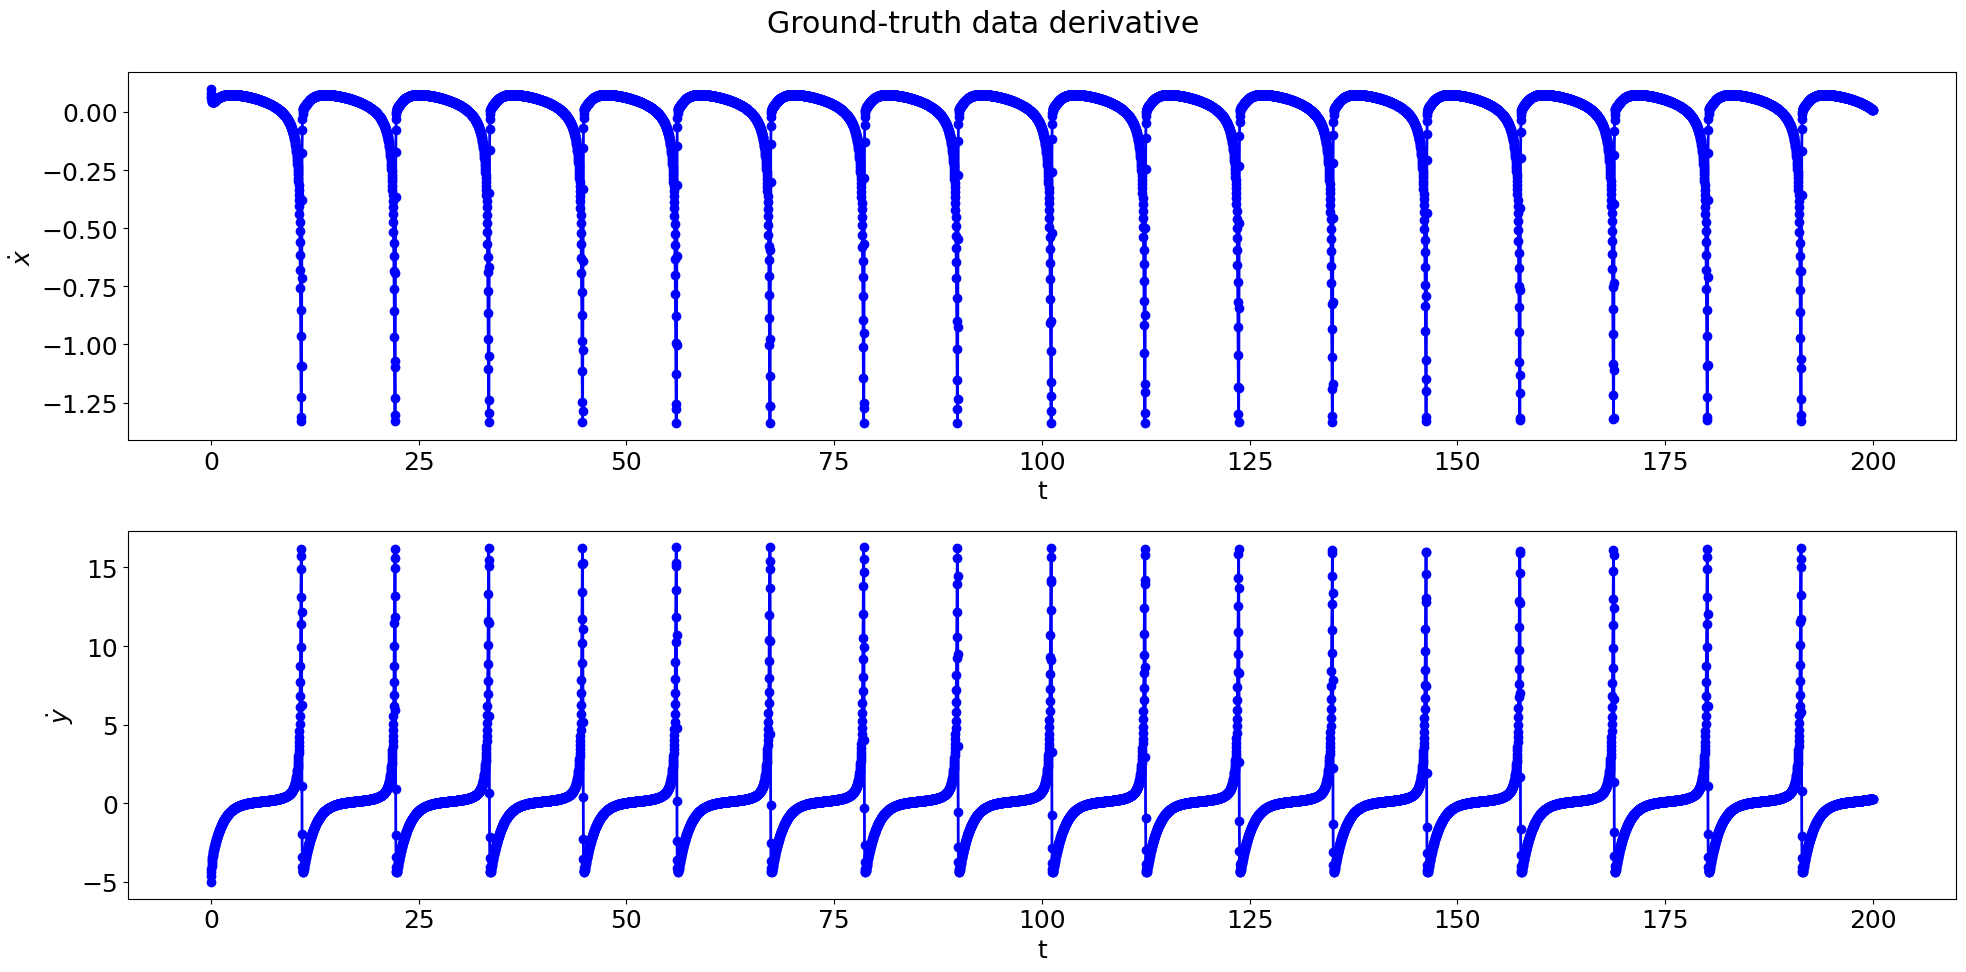

In [3]:
def DERIVATIVE(x,y,a,b,k,mu):

    dxdt = -k*x*np.exp(a*y) + mu
    dydt = x*np.exp(b*y) - y

    return np.vstack((dxdt, dydt)).T

A1A2_time_deriv = DERIVATIVE ( x, y, a, b, k, mu)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
fig.suptitle('Ground-truth data derivative')

# Plot dA/dt
ax[0].plot(t, A1A2_time_deriv[:, 0], '-o', color='blue', linewidth=2)
ax[0].set(xlabel="t", ylabel=r"$\dot{x}$")

# Plot dP/dt
ax[1].plot(t, A1A2_time_deriv[:, 1], '-o', color='blue', linewidth=2)
ax[1].set(xlabel="t", ylabel=r"$\dot{y}$")

fig.tight_layout()
plt.show()

In [4]:
## SINDy Function Definitions
def poolData(yin,nVars,polyorder):
    n = yin.shape[0]
    yout = np.zeros((n,1))

    # poly order 0
    yout[:,0] = np.ones(n)

    # poly order 1
    for i in range(nVars):
        yout = np.append(yout,yin[:,i].reshape((yin.shape[0],1)),axis=1)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i,nVars):
                yout = np.append(yout,(yin[:,i]*yin[:,j]).reshape((yin.shape[0],1)),axis=1)

    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i,nVars):
                for k in range(j,nVars):
                    yout = np.append(yout,(yin[:,i]*yin[:,j]*yin[:,k]).reshape((yin.shape[0],1)),axis=1)

    return yout

def sparsifyDynamics(Theta,dXdt,lamb,n): #Solves SINDy's L1 regularized convex optimization problem
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]

    return Xi

In [5]:

nums = [1.0]              #numbers in the denominator [ sin(pi/a)]
sin_freq = np.pi / np.array(nums)     #frequencies for sin and cos function

x_exp_powers = [ 1.0, 2.0]          #coefficients for exponential of x [exp(a*x)] 
y_exp_powers = [ 1.0, 2.0]          #coefficents for exponential of y [exp(a*y)]



def generate_candidates(x_t, sin_freq, x_exp_powers, y_exp_powers):
    """
    Generates polynomial, sine, cosine, and exponential terms, and their combinations
    based on input data. Handles cases where x_t has dimensions (1000, 2) or (1, 2).
    
    Parameters:
    x_t : array-like of shape (N, 2)
        Input data for N data points with two variables (x and y).
    sin_freq : list of float
        Frequencies for sine and cosine functions.
    x_exp_powers : list of float
        Coefficients for the exponential of x (exp(a*x)).
    y_exp_powers : list of float
        Coefficients for the exponential of y (exp(a*y)).
    
    Returns:
    All_candidates : array-like
        Combined matrix of polynomial, sine, cosine, and exponential terms.
    """
    
    # Extract x and y from x_t
    x = x_t[:, 0]  # First column is x
    y = x_t[:, 1]  # Second column is y
    
    # Polynomial terms (modify poolData if needed to handle both shapes)
    polynomial = poolData(x_t, 2, 1)
    poly_candidate = polynomial[:, 1:]
    
    N_sin_freq = len(sin_freq)
    
    # Fourier terms
    Nsize = poly_candidate.shape[1] * N_sin_freq
    sine_candidate = np.zeros((poly_candidate.shape[0], Nsize))
    cos_candidate = np.zeros((poly_candidate.shape[0], Nsize))
    
    k = 0
    for i in range(poly_candidate.shape[1]):
        for j in range(N_sin_freq):
            sine_candidate[:, k] = np.sin(poly_candidate[:, i] * sin_freq[j])
            cos_candidate[:, k] = np.cos(poly_candidate[:, i] * sin_freq[j])
            k += 1
    
    # Fourier terms * polynomial terms
    xsine_candidate = np.zeros((poly_candidate.shape[0], Nsize * poly_candidate.shape[1]))
    xcos_candidate = np.zeros((poly_candidate.shape[0], Nsize * poly_candidate.shape[1]))
    
    k = 0
    for i in range(Nsize):
        for j in range(poly_candidate.shape[1]):
            xsine_candidate[:, k] = sine_candidate[:, i] * poly_candidate[:, j]
            xcos_candidate[:, k] = cos_candidate[:, i] * poly_candidate[:, j]
            k += 1
    
    # Exponential terms
    x_exp_powered = np.array([np.exp(x * p) for p in x_exp_powers]).T  # Shape (N, len(x_exp_powers))
    y_exp_powered = np.array([np.exp(y * p) for p in y_exp_powers]).T  # Shape (N, len(y_exp_powers))
    
    # Combine x and y exponential terms
    all_exp = np.hstack([x_exp_powered, y_exp_powered])
    
    # Polynomial * exponential terms
    x_exp_combination = np.concatenate([poly_candidate * x_exp[:, None] for x_exp in x_exp_powered.T], axis=1)
    y_exp_combination = np.concatenate([poly_candidate * y_exp[:, None] for y_exp in y_exp_powered.T], axis=1)
    
    # Combine all exponential terms
    #all_exp_combinations = np.hstack([all_exp, x_exp_combination, y_exp_combination])
    all_exp_combinations = np.hstack([ x_exp_combination, y_exp_combination])
    
    # Combine all candidate terms
    #All_candidates = np.hstack((polynomial, sine_candidate, cos_candidate, xsine_candidate, xcos_candidate, all_exp_combinations))
    All_candidates       = np.hstack((polynomial, sine_candidate , all_exp_combinations))
    
    return All_candidates


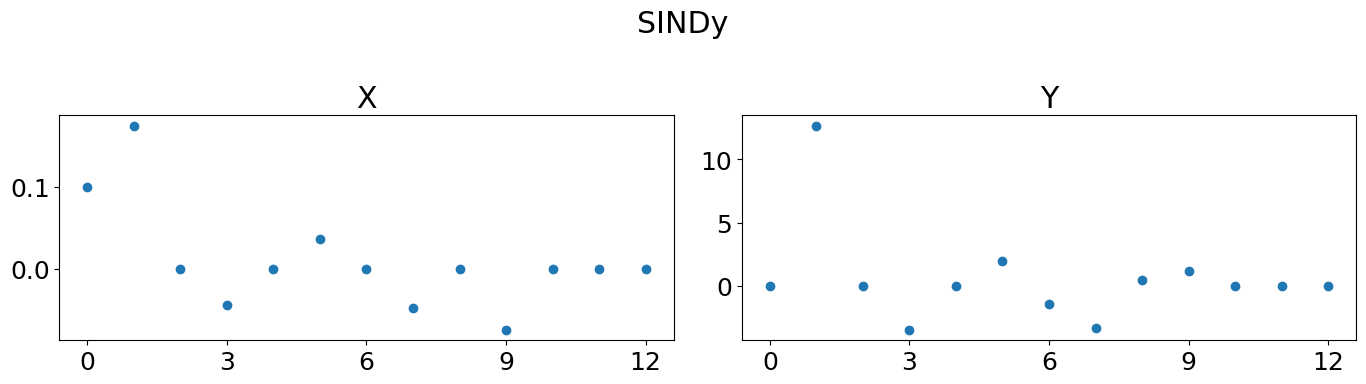

[ 0.09910138015022   0.174667407994193  0.
 -0.044217213894493  0.                 0.035748093446123
  0.                -0.048689015811023  0.
 -0.075090921589254  0.                 0.
  0.               ]
[ 0.028797099314907 12.650511268393448  0.
 -3.483915090298451  0.                 1.944818128070825
 -1.459299386772078 -3.286722325788518  0.454126626297215
  1.15341287612836   0.                 0.
  0.               ]


In [6]:
Candidates = generate_candidates (x_t, sin_freq=sin_freq, x_exp_powers=x_exp_powers, y_exp_powers=y_exp_powers)

lamb = 0.025# sparsification knob lambda
coeff_matrix = sparsifyDynamics(Candidates, A1A2_time_deriv, lamb, 2)
#print(coeff_matrix)
threshold = 0.00001
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('SINDy')

ax[0].plot(coeff_matrix [:, 0], 'o')
ax[0].set_title('X')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(coeff_matrix [:, 1], 'o')
ax[1].set_title('Y')
ax[1].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()

print(coeff_matrix[:, 0])
print(coeff_matrix[:, 1])

In [7]:
def SINDy_oscillator_deriv(x_y, t):
    out = generate_candidates (np.array(x_y)[np.newaxis, :], sin_freq=sin_freq, x_exp_powers=x_exp_powers, y_exp_powers=y_exp_powers)@coeff_matrix
    return np.squeeze(out).tolist()

np.random.seed(123)
x0 = (0, 5)
x1_t = integrate.odeint(SINDy_oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x1, y1 = x1_t.T

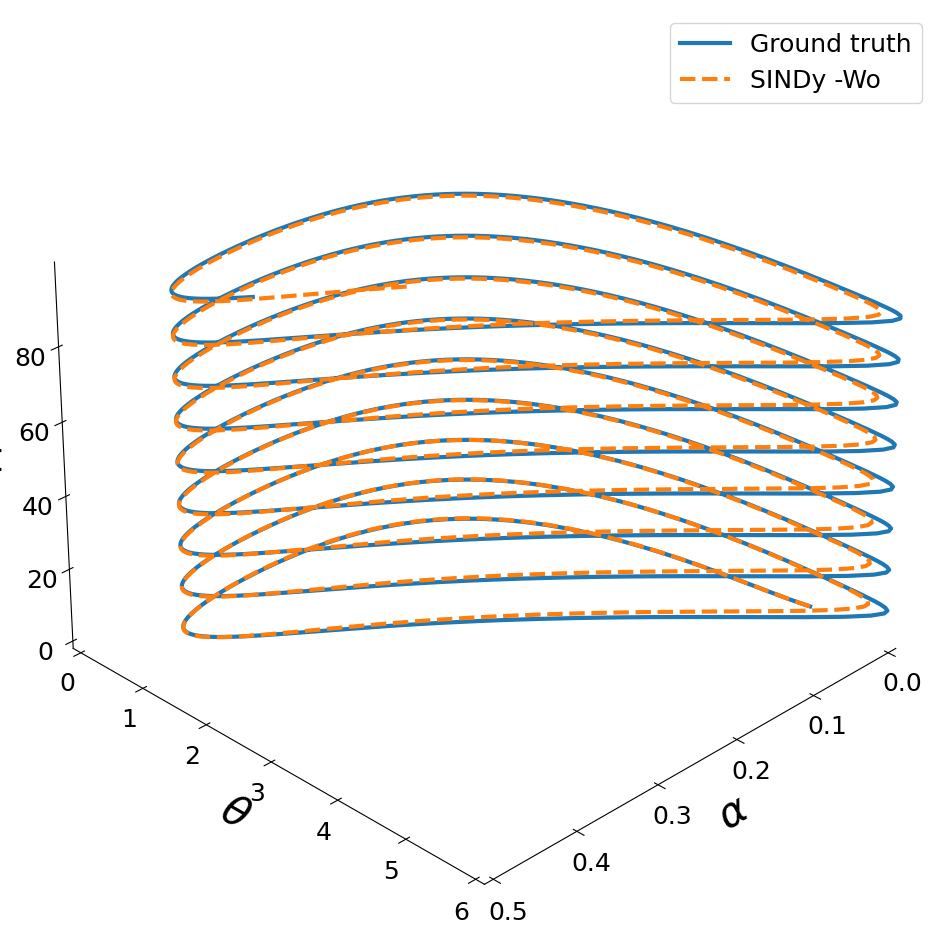

In [8]:
# Create figure and 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plotting the data
ax.plot(x[t<=100],  y[t<=100], t[t<=100], label="Ground truth", linewidth=3)
ax.plot(x1[t<=100], y1[t<=100], t[t<=100], label="SINDy -Wo", linestyle='--', linewidth=3)

# Adding the legend
ax.legend()

# Setting labels with Times New Roman font
ax.set_xlabel(r"$\alpha$", labelpad=8, fontsize = 30)
ax.set_ylabel(r"$\theta$", labelpad=8, fontsize = 30)
ax.set_zlabel("t", labelpad=8, fontsize = 30)


# Set limits for x and y axes
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 6)

# Remove background pane and borders
ax.xaxis.pane.fill = False  # Remove background pane for x-axis
ax.yaxis.pane.fill = False  # Remove background pane for y-axis
ax.zaxis.pane.fill = False  # Remove background pane for z-axis

# Turn off the pane borders
ax.xaxis.pane.set_edgecolor('none')  # No border for x-axis pane
ax.yaxis.pane.set_edgecolor('none')  # No border for y-axis pane
ax.zaxis.pane.set_edgecolor('none')  # No border for z-axis pane

# Remove grid
ax.grid(False)

ax.view_init(30, 45, 0)
# Save figure to a PDF file
plt.savefig('Comparison(SINDY-Wo).jpeg', dpi = 1200)

# Display plot
plt.show()

In [9]:
print(np.linalg.norm(x1_t - x_t, ord=2) / x.size)

0.009530310619441528
